# Importar librerias

In [1]:
c = 8 # Valor para variables climaticas

In [2]:
import time
start = time.time()
#importar datos y librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import signal
from scipy import special
from scipy.ndimage.interpolation import shift

import sklearn
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline

In [3]:
# Plotly
import chart_studio.plotly as ply
import cufflinks as cf
cf.go_offline()

# Funciones

In [4]:
# para calcular el mape
def Mape(y,y_pred):
    return np.mean(np.abs((y-y_pred)/y))*100

# para hacer kronecker por fila
def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

# para crear variables difusas
def triangular():
    # Se crea x
    ma = pd.DataFrame();
    x = consumofeb.index.dayofyear.to_list()
    # Se crean variables a, b y c
    for hei in height:
        ba = pd.DataFrame(x, columns=["x"])
        ba["a"] = height[hei][0]
        ba["b"] = height[hei][1]
        ba["c"] = height[hei][2]
        # Variable difusa
        ca = pd.DataFrame()
        ca["bo"] = (ba.x-ba.a)/(ba.b-ba.a)
        ca["ba"] = (ba.c-ba.x)/(ba.c-ba.b)
        ca = ca.min(axis = 1)
        ca[ca<0]=0
        ma = pd.concat([ma, ca], axis = 1) # Se concatenan
        
    ma.index = consumofeb.index
    ma.columns = height.keys()
    return ma

In [5]:
# triangular()

# Cargar datos

In [6]:
consumofeb=pd.read_excel(r'Consumo_feb.xlsx').set_index("fecha").loc["2007-01-01":"2020-03-30"]# variables climaticas
consumofeb=consumofeb.drop(["prom","Lluvia","Velocidad_viento"],1) # variables no importantes para el modelo
consumo=pd.read_excel('.\Data1.xlsx').set_index("fecha").loc["2007-01-01":"2020-03-30"] # consumo de energia en MWh

In [7]:
if len(consumofeb.index) == len(consumo.index): print("ok")

ok


 # Variables difusas

In [8]:
height = {
    'Invierno1': [310.5-365.25, 8.6529, 138.941176470588],
  'Primavera': [8.6529, 138.941176470588, 221.9375],
  'verano': [138.941176470588, 221.9375, 310.5],
  'Otoño': [221.9375, 310.5, 365.25+8.6529],
    'Otoño2': [221.9375-365.25, 310.5-365.25, 8.6529],
  'Invierno2': [310.5, 365.25+8.6529, 365.25+138.941176470588],} 

-  Para graficar

In [9]:
# triangular().iplot()

# Variables climaticas

In [12]:
def pba(j, n):
    # armonicos
    f, asd = signal.periodogram(consumofeb[j], 1)
#     plt.figure()
#     plt.plot(1/f, asd)
    picos = pd.DataFrame(asd, 1/(f), columns=["potencia"])
    picos = picos.sort_values(by="potencia",ascending=False).reset_index().head(12)
    picos.columns = ["periodo", "potencia"]
    #fourier
    sencos = pd.DataFrame(index = consumofeb.index)
    t = np.arange(1,len(consumofeb)+1)
    sencos["t"]=t
    for i  in  picos.periodo:
            sencos[f"{i:.2f}_sen"] = np.abs(np.sin(((2*np.pi)/(i))*t))
            sencos[f"{i:.2f}_cos"] = np.abs(np.cos(((2*np.pi)/(i))*t))
    sencos['ones']=1
    sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
    sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
    
    sencos=kronecker(sencos, triangular())
    #regresion
    X_train, X_test, y_train, y_test = train_test_split(sencos, consumofeb[j], test_size=n, shuffle = False)
    
    reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    y_predict=reg.predict(X_test)
    
#     plt.figure()
#     plt.plot(y_test , label="real")
#     plt.plot(y_test.index, y_predict,label="predicción")

#     plt.figure()
#     plt.plot(y_train)
#     plt.plot(y_train.index, reg.predict(X_train))
#     print(Mape(y_train,reg.predict(X_train),1))
    
    nov=pd.DataFrame(np.concatenate([reg.predict(X_train),y_predict]),index=consumofeb.index,columns=[f"{j}"])

    return nov

In [13]:
def modelosclima(n):
    ca = pd.DataFrame(index = consumo.index)
    for i in ["mín", "max", "Nubosidad"]:
        ca = pd.concat([ca, pba(i, n)], axis = 1)
    return ca

In [14]:
# Se corre y guarda en una variable los datos de clima predichos
modclima = modelosclima(c)

# Varibles festivos

In [15]:
def festivos():
    festivos=pd.read_excel('.\Festivos.xlsx')
    festivos2=pd.read_excel('.\Festivos2.xlsx')

    Dum = pd.DataFrame(index = consumo.index)

    for col in festivos.columns:
        Dum[f"{col}"] = consumo.index.isin(festivos[f"{col}"])
        Dum[col] = Dum[col].replace([False, True],[0, 1])
        clean = Dum[col].values
        Dum[col] = Dum[col]+shift(clean, 1, cval=0)*.4
        Dum[col] = Dum[col]+shift(clean, -1, cval=0)*.4
        Dum[col] = Dum[col]+shift(clean, 2, cval=0)*.1
        Dum[col] = Dum[col]+shift(clean, -2, cval=0)*.1
        Dum[col] = Dum[col]/2

    Dum["ones"] = 1
    te = np.arange(1,len(consumo.index)+1)    
    Dum["t"]= te/np.max(te)
    
    for col in festivos2.columns:
        Dum[col] = consumo.index.isin(festivos2[col])
    Dum = Dum.replace([False, True],[0, 1])
    
    return Dum

# Todas las variables dependientes

In [16]:
def dummies(n):   
    # variables eureka y clima
    consumo2 = pd.DataFrame(index=consumo.index)
    consumo2["num"] = np.arange(1,len(consumo.index)+1)
    consumo2["day"] = consumo.index.weekday
    consumo2["eureka1"] = consumo2.day**3
    consumo2["eureka2"] = modclima["max"]*consumo2.num
    consumo2["month"] = consumo.index.month
    X = consumo2.join(modclima)
    # normalizacion eureka-clima
    X_norm = X/X.max()
    
    # variables gplearn
    X_norm["gplearn1"]=np.cos(X_norm.day)*X_norm.num
    X_norm["gplearn2"]=X_norm.num*X_norm["mín"]
    X_norm["gplearn3"]=3.319**X_norm["max"]*np.cos(X_norm.day)
    X_norm["gplearn8"]=3.319**X_norm["max"]*X_norm.num 
    X_norm["gplearn4"]=np.cos(X_norm.day)*np.sin(X_norm.day)
    X_norm["gplearn6"]=X_norm["max"]**2*X_norm["mín"]**2
    X_norm["gplearn7"]=1/np.cos(X_norm.day)
    X_norm["gplearn10"]=X_norm["max"]*X_norm["mín"]**3*np.cos(X_norm.month)**2
    # variables dummies
    X_norm = pd.get_dummies(X_norm, columns=["month", "day"], prefix=["month", "day"], drop_first=True)

    # variables festivos y difusa de clima
    X_norm = X_norm.join(festivos())
    X_norm = X_norm.join(triangular())
    
    # variables entre y fin
    X_norm["fin"]=consumo.index.weekday
    X_norm["entre"]=consumo.index.weekday
    X_norm["fin"]=X_norm["fin"].replace([0,1,2,3,4,5,6],[.5,0,0,0,.5,1,1])
    X_norm["entre"]=X_norm["entre"].replace([0,1,2,3,4,5,6],[.5,1,1,1,.5,0,0])
    return X_norm

In [17]:
beg = time.time()
dummies(7)
end = time.time()
end - beg

0.44106125831604004

# Para separar $x$ y $y$

In [18]:
def separar(n, X, y):
    # separar X y Y
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                  test_size = n, shuffle = False)
    return (X_train, X_test), (y_train, y_test)

# Primer regresion

In [19]:
def reg(n, pre_forc): # n = 7 , pre_for = "general" o "forecasting"
    # cargar X y Y
    y = consumo; X = dummies(n)
    # Se obtienen los datos separados
    Xo, yo = separar(n, X, y)  
    # Decision "general" "forecasting"
    if pre_forc == "general": pre_forc = 0
    elif pre_forc == "forecasting": pre_forc = 1
    else: print(f"expected `general` or `forecasting`, got {pre_forc} instead")
    # regresion y predeccion    
    reg = LinearRegression(n_jobs =-1).fit(Xo[0], yo[0])
    y_predict=reg.predict(Xo[pre_forc])
    
    # dataframe real-predict- resta
    comp = pd.DataFrame(y_predict, columns = ["predict"],index = yo[pre_forc].index)
    comp["real"] = yo[pre_forc]; comp["resta"] = comp.real - comp.predict
    return comp

- Para graficar

In [20]:
def visual1(n):
    regio = reg(n, "general")
    rego = regio[["predict", "real"]]
    
    rego.iplot(title = f"general: {Mape(*rego.values.T)}")
    regio.resta.iplot(title = "resta")
    
    regal = reg(n, "forecasting")[["predict", "real"]]
    regal.iplot(title = f"forecasting: {Mape(*regal.values.T)}")

In [21]:
# visual1(7)

# Periodos en residuales

In [22]:
def perio(n, fg):
    # Periodograma de resta real - pred
    reg1 = reg(n, fg)
    
    f, asd = signal.periodogram(reg1.resta, 1)
    
#     # graficar
#     plt.plot(1/f, asd); plt.xlabel('periodo'); plt.ylabel('PSD')

    # DataFrame con columna de potencia y columna de 
    picos = pd.DataFrame(asd, columns=["potencia"])
    picos["periodo"] = 1/f
    picos = picos.sort_values(by="potencia",ascending=False).reset_index(drop = True).head(12)
    return picos[2:12]

In [23]:
# perio(7, "general")

# Kronecker Sencos-dummies

In [24]:
def kron(n):
    # Se llama a X y a Y
    X = dummies(n) 
    # Se crea dataframe de fourier
    sencos = pd.DataFrame()
    t = np.arange(1,len(consumo.MWh)+1)
    sencos["t"]=t
    
    # Mando llamar la funcion de armonicos
    p = perio(n, "general")
    
    # fourier
    for i  in  p.periodo:
            sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/(i))*t))
            sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/(i))*t))
    sencos['ones']=1
    sencos['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
    sencos['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
    sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
    sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
    sencos['sen2']=np.abs(np.sin(((2*np.pi)/(28))*t))
    sencos['cos2']=np.abs(np.cos(((2*np.pi)/(28))*t))
#     sencos['sen3']=np.abs(np.sin(((2*np.pi)/(241.25))*t))
#     sencos['cos3']=np.abs(np.cos(((2*np.pi)/(241.25))*t))
    sencos.index =consumo.index
    
    # Kronecker
    combination=corc(X, sencos)
    return combination

# Segunda regresion

In [25]:
def reg2(n, pre_forc): # n = 7 , pre_for = "general" o "forecasting"
    # Se llama a X y a Y
    X = kron(n); y = consumo
    
    # split
    Xo, yo = separar(n, X, y) 
    
    # Decision "general" "forecasting"
    if pre_forc == "general": pre_forc = 0
    elif pre_forc == "forecasting": pre_forc = 1
    else: print(f"expected `general` or `forecasting`, got {pre_forc} instead")
        
    # regresion y predeccion    
#     reg = LinearRegression(n_jobs =-1).fit(Xo[0], yo[0])
    lasso_reg = Lasso(normalize=True,max_iter=10000).fit(Xo[0], yo[0])
    y_predict = lasso_reg.predict(Xo[pre_forc])

    
    # dataframe real-predict- resta
    comp = pd.DataFrame(y_predict, columns = ["predict"],index = yo[pre_forc].index)
    comp["real"] = yo[pre_forc]; comp["resta"] = comp.real - comp.predict
    return comp

# para observar residuos

In [26]:
from scipy.signal import find_peaks
import cupy as cp

In [27]:
def corc(data1:'Dataframe 1',data2:'Dataframe 2'):
    nom = [f'{i}_{j}' for i in data2.columns for j in data1.columns] # nombres

    a = cp.array(data1).T
    b = cp.array(data2)
    cp.cuda.Stream.null.synchronize() #conversion a Cupy
    
    m, k = a.shape
    d = cp.zeros((k, 1))
    cp.cuda.Stream.null.synchronize() #vector de ceros para multiplicar
        
    for i in range(m):
        c = cp.multiply(a[[i]].T, b)
        d = cp.concatenate((d, c), 1)
    cp.cuda.Stream.null.synchronize() #kronecker
    
    d = cp.asnumpy(d)       #conversion a numpy
    d = np.delete(d, 0, 1)  #eliminar columna de ceros
    bob = pd.DataFrame(d, columns = nom, index = data1.index)#pandas
    return bob

In [28]:
def clorous(n):
    vals = reg2(n, "general")[["resta"]]
    # bob = seasonal_decompose(vals, model='additive').seasonal.to_numpy()
    fa, asmde = signal.periodogram(vals.to_numpy()[:,0])
    peaks, _ = find_peaks(asmde, height=0)
    # 1/fa[peaks]
    bap = 1/fa[peaks[np.argsort(_["peak_heights"])[::-1]]][2:]
    t = np.arange(1,len(consumo.MWh)+1)
    sencos = pd.DataFrame()
#     sencos["t"]=t/np.max(t)
    
    # Mando llamar la funcion de armonicos
    p = bap
    
    # fourier
    for i  in  p:
            sencos["{:.2f}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/(i))*t))
            sencos["{:.2f}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/(i))*t))
#     sencos['ones']=1
#     sencos['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
#     sencos['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
#     sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
#     sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
#     sencos['sen2']=np.abs(np.sin(((2*np.pi)/(28))*t))
#     sencos['cos2']=np.abs(np.cos(((2*np.pi)/(28))*t))
#     sencos['sen3']=np.abs(np.sin(((2*np.pi)/(241.25))*t))
#     sencos['cos3']=np.abs(np.cos(((2*np.pi)/(241.25))*t))
    sencos.index =consumo.index
    return sencos, vals

In [29]:
# clorous(7)[0]

In [31]:
def regina(n):
    X, y = clorous(n)
#     X = dummies(n)
#     X = X.join(dummies(n))
#     X = kronecker(X, dummies(n))
    X_train, X_test = train_test_split(X, test_size = n, shuffle = False)
#     regi = LinearRegression(n_jobs = -1).fit(X_train, y)
    regi = Lasso(normalize = True).fit(X_train, y)
    predo = regi.predict(X_test)
#     y["pred"] = predo
    return predo

In [ ]:
regina(7)

In [ ]:
regina(7).iplot()

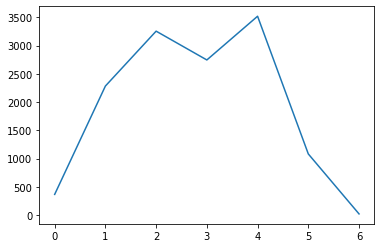

In [431]:
plt.plot(regina(7)

In [446]:
reg2(7, "forecasting").resta.shape

(7,)

In [510]:
ba = pd.DataFrame(reg2(20, "forecasting").resta)
ba["bol"] = regina(20)

In [511]:
ba.iplot()

In [493]:
bo.iplot()

In [447]:
regina(7)

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [288]:
vals = reg2(7, "general")[["resta"]]

In [312]:
bob = seasonal_decompose(vals, model='additive').seasonal.to_numpy()
fa, asmde = signal.periodogram(bob)
peaks, _ = find_peaks(asmde, height=0)
1/fa[peaks]

array([7.00144928, 3.50072464, 2.33381643])

- para graficar

In [278]:
def visual2(n):
    regio = reg2(n, "general")
    rego = regio[["predict", "real"]]
    
    rego.iplot(title = f"general: {Mape(*rego.values.T)}")
    regio.resta.iplot(title = "resta")
    
    regal = reg2(n, "forecasting")[["predict", "real"]]
    regal.iplot(title = f"forecasting: {Mape(*regal.values.T)}")

In [279]:
# visual2(10)

# Arima

In [381]:
def aroma(n):
    # llamar X
    cas = festivos().drop(["ones"],1).join(triangular())
    X, X_te = train_test_split(cas, test_size = n, shuffle = False)
    # llamar y
    result = reg2(n, "general").resta
    # arima
    step_wise=auto_arima(result,exog=X, start_p=1, start_q=1, max_p=7, max_q=7, max_d=1,
                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True,m=1,
                    seasonal=False,Stationary=True) #
    
    mod = ARIMA(result, order=step_wise.order) #exog = X
    results = mod.fit()

    return results, X # modelo

# ver arima

In [33]:
cas = festivos().drop(["ones"],1).join(triangular())
X, X_te = train_test_split(cas, test_size = 20, shuffle = False)
# llamar y
result = reg2(20, "general").resta
# arima
step_wise=auto_arima(result,exog=X, start_p=1, start_q=1, max_p=7, max_q=7, max_d=1,
                 trace=True, error_action='ignore', suppress_warnings=True, stepwise=True,m=1,
                seasonal=False,Stationary=True) #

mod = ARIMA(result, order=step_wise.order) #exog = X
results = mod.fit()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=89921.163, BIC=89947.083, Time=3.695 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=90524.600, BIC=90537.559, Time=0.140 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=90291.607, BIC=90311.047, Time=0.374 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=90232.245, BIC=90251.684, Time=0.482 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=90522.600, BIC=90529.080, Time=0.100 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=89870.947, BIC=89903.346, Time=4.946 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=89878.423, BIC=89910.822, Time=3.615 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inve

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [59]:
mod = ARIMA(result, order=(7, 2, 0))
ba = mod.fit()

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [57]:
lok = reg2(7, "forecasting").resta

In [62]:
pab = pd.concat([pd.DataFrame(ba.forecast(steps = 7)[0], index = consumo.tail(7).index, columns = ["predict"]), lok], 1)
mp = np.abs((np.abs(pab.resta) - np.abs(pab.predict))/np.abs(pab.resta))*100
pab.iplot(title = mp.mean())

In [63]:
ba.fittedvalues.iplot()

# Tercer regresion

In [281]:
def reg3(n):
    X = kron(n)
    X_train, X_test, y_train, y_test = train_test_split(X, consumo, test_size = n, shuffle = False)
    #arima
    results, X_t = aroma(n)   
    # prediccion con arima
    extra=results.predict(len(y_train),len(y_train)+n)[1:] #len(y_train),len(y_train)+n,
    
    # regresion con lasso
    lasso_reg = Lasso(normalize=True,max_iter=1000).fit(X_train,y_train)
    y_pred_lass = lasso_reg.predict(X_test)
    print(len(lasso_reg.coef_))

    # predict, real, resta
    comp = pd.DataFrame(y_pred_lass + extra.values, columns = ["predict"],index = y_test.index)
    comp["real"] = y_test; comp["resta"] = comp.real - comp.predict
    return comp

In [283]:
beg = time.time()
ba = reg3(20)
end = time.time()
print(f" timepo de corrida: {(end - beg)/60} min")

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 420696965.5793762, tolerance: 217075769.1651876



Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=89927.718, BIC=89953.637, Time=3.983 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=90531.660, BIC=90544.620, Time=0.145 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=90298.359, BIC=90317.799, Time=0.409 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=90238.956, BIC=90258.396, Time=0.533 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=90529.660, BIC=90536.140, Time=0.134 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=89888.857, BIC=89921.257, Time=3.513 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=89875.927, BIC=89908.327, Time=6.595 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inve

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1764
 timepo de corrida: 0.8548746466636657 min


C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 420696965.5793762, tolerance: 217075769.1651876



- para graficar

In [284]:
ai = Mape(*ba[["predict", "real"]].values.T)
ba[["predict", "real"]].iplot(title = f"Mape: {ai:.3f}")

In [285]:
ba

,predict,real,resta
fecha,,,
2020-03-11,205947.981186,209419.851507,3471.870321
2020-03-12,205632.008236,212493.446000,6861.437764
2020-03-13,205100.912097,211848.227000,6747.314903
2020-03-14,194793.484113,198746.125920,3952.641807
2020-03-15,174572.516554,172471.601743,-2100.914811
2020-03-16,180697.049998,172167.134553,-8529.915445
2020-03-17,207119.039519,196979.657000,-10139.382519
2020-03-18,208099.324430,209386.045000,1286.720570
2020-03-19,207612.066239,207798.931000,186.864761
